In [20]:
# import the libaray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error, mean_squared_error

import itertools
import statsmodels.api as sm

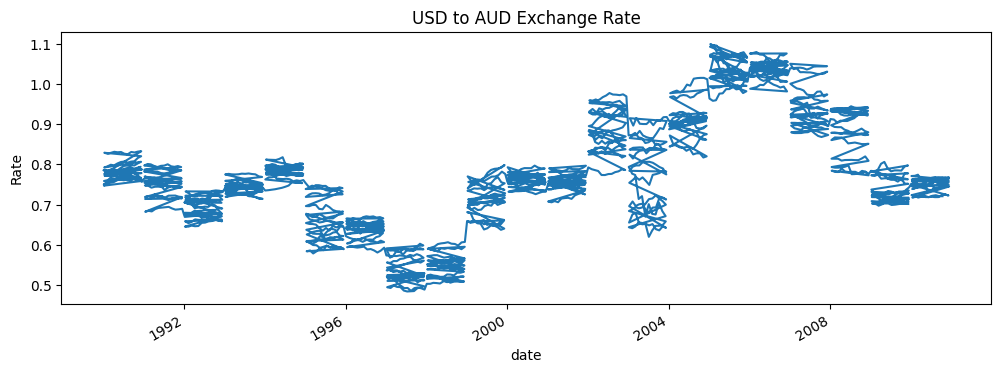

Train size: 2398  Test size: 600


In [22]:
# -----------------------
# Part 1: Data Preparation
# -----------------------
# Load dataset
df = pd.read_csv("/content/exchange_rate.csv")

# Force date column to datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Drop rows with invalid dates (NaT)
df = df.dropna(subset=["date"])

# Set index
df = df.rename(columns={"Ex_rate": "USD_AUD"}).set_index("date")

# Handle missing values (interpolate along time, fallback ffill/bfill)
df["USD_AUD"] = df["USD_AUD"].interpolate(method="time")
df["USD_AUD"] = df["USD_AUD"].fillna(method="ffill").fillna(method="bfill")

# Plot full series
df["USD_AUD"].plot(figsize=(12,4), title="USD to AUD Exchange Rate", ylabel="Rate")
plt.show()
# Train-test split (80/20)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Ensure clean train/test
train["USD_AUD"] = train["USD_AUD"].replace([np.inf, -np.inf], np.nan).dropna()
test["USD_AUD"]  = test["USD_AUD"].replace([np.inf, -np.inf], np.nan).dropna()

print("Train size:", len(train), " Test size:", len(test))



ADF Statistic: -0.8606741281112138
p-value: 0.800647077402024


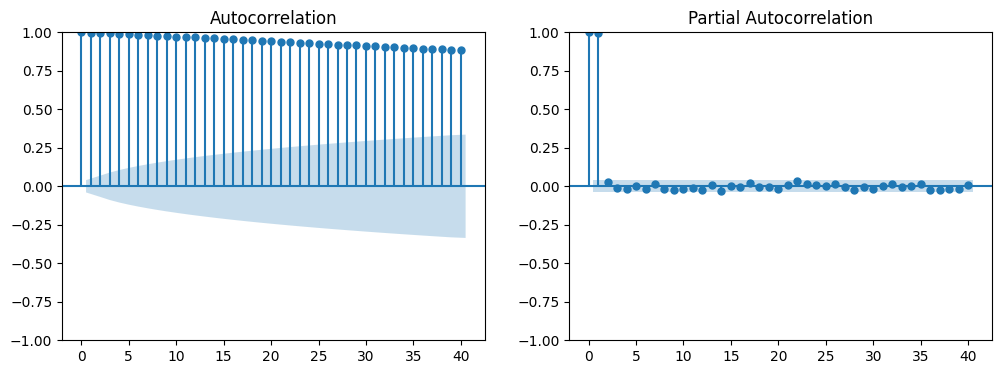

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsm

Best ARIMA order: (1, 1, 0) with AIC: -16012.132660871512


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 2398
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8008.066
Date:                Tue, 23 Sep 2025   AIC                         -16012.133
Time:                        18:06:15   BIC                         -16000.569
Sample:                             0   HQIC                        -16007.925
                               - 2398                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0332      0.019     -1.747      0.081      -0.070       0.004
sigma2       7.34e-05   6.53e-07    112.487      0.000    7.21e-05    7.47e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

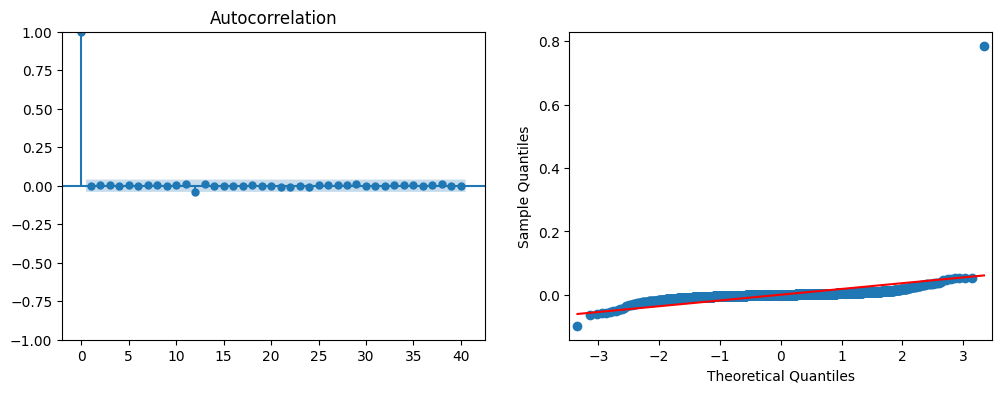

     lb_stat  lb_pvalue
10  0.606281   0.999983


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


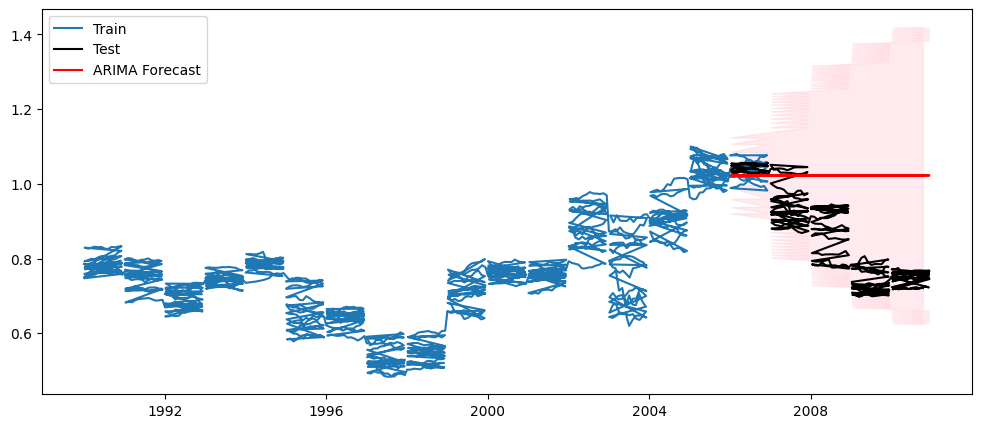

In [23]:
# Part 2: ARIMA Modeling
# 2.1 Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# 2.2 Stationarity Test

adf_result = adfuller(train["USD_AUD"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


# 2.3 ACF/PACF Plots

fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(train["USD_AUD"], ax=ax[0], lags=40)
plot_pacf(train["USD_AUD"], ax=ax[1], lags=40)
plt.show()
p = q = range(0,3)
d = [0,1]
best_aic = np.inf
best_order = None
for order in itertools.product(p,d,q):
    try:
        model = ARIMA(train["USD_AUD"], order=order)
        res = model.fit()
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = order
    except:
        continue

print("Best ARIMA order:", best_order, "with AIC:", best_aic)

# 2.5 Fit ARIMA Model

arima_model = ARIMA(train["USD_AUD"], order=best_order)
arima_res = arima_model.fit()
print(arima_res.summary())

# Residual diagnostics
resid = arima_res.resid
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_acf(resid, lags=40, ax=ax[0])
sm.qqplot(resid, line="s", ax=ax[1])
plt.show()
print(acorr_ljungbox(resid, lags=[10], return_df=True))


# 2.6 Forecast with ARIMA

fc = arima_res.get_forecast(steps=len(test))
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

plt.figure(figsize=(12,5))
plt.plot(train.index, train["USD_AUD"], label="Train")
plt.plot(test.index, test["USD_AUD"], label="Test", color="black")
plt.plot(test.index, fc_mean, label="ARIMA Forecast", color="red")
plt.fill_between(test.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], color="pink", alpha=0.3)
plt.legend(); plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages

Best Holt-Winters params: (None, None, None) RMSE: 0.20552024855934625


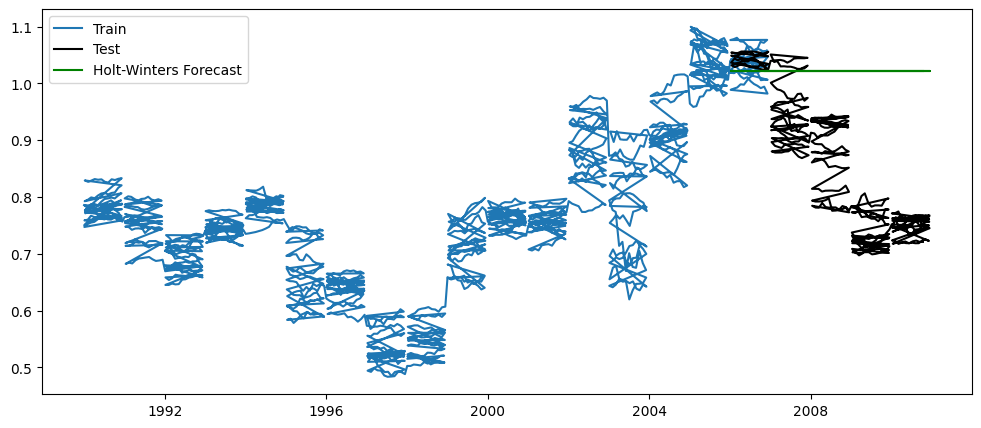

In [24]:
# Part 3: Exponential Smoothing (Holt-Winters)
# 3.1 Parameter Grid Search
best_rmse = np.inf
best_params = None
best_model = None

for trend in [None, "add", "mul"]:
    for seasonal in [None, "add", "mul"]:
        for sp in [None, 6, 12]:
            try:
                model = ExponentialSmoothing(
                    train["USD_AUD"],
                    trend=trend,
                    seasonal=seasonal,
                    seasonal_periods=sp
                ).fit()
                preds = model.forecast(len(test))
                rmse = np.sqrt(mean_squared_error(test["USD_AUD"], preds))
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (trend, seasonal, sp)
                    best_model = model
            except:
                continue

print("Best Holt-Winters params:", best_params, "RMSE:", best_rmse)

# 3.2 Forecast with Holt-Winters
hw_forecast = best_model.forecast(len(test))

plt.figure(figsize=(12,5))
plt.plot(train.index, train["USD_AUD"], label="Train")
plt.plot(test.index, test["USD_AUD"], label="Test", color="black")
plt.plot(test.index, hw_forecast, label="Holt-Winters Forecast", color="green")
plt.legend(); plt.show()


In [27]:
# Part 4: Evaluation & Comparison
def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask]-y_pred[mask]) / y_true[mask]))*100

results = pd.DataFrame({
    "Model": ["ARIMA", "Holt-Winters"],
    "MAE": [
        mean_absolute_error(test["USD_AUD"], fc_mean),
        mean_absolute_error(test["USD_AUD"], hw_forecast)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test["USD_AUD"], fc_mean)),
        np.sqrt(mean_squared_error(test["USD_AUD"], hw_forecast))
    ],
    "MAPE": [
        safe_mape(test["USD_AUD"].values, fc_mean.values),
        safe_mape(test["USD_AUD"].values, hw_forecast.values)
    ]
})

print(results.set_index("Model"))




                   MAE      RMSE       MAPE
Model                                      
ARIMA         0.177924  0.205519  22.854688
Holt-Winters  0.177925  0.205520  22.854830


In [28]:
# Part 5: Conclusion
if results.loc[0, "RMSE"] < results.loc[1, "RMSE"]:
    print("\nConclusion: ARIMA performed better based on RMSE.")
else:
    print("\nConclusion: Holt-Winters performed better based on RMSE.")


Conclusion: ARIMA performed better based on RMSE.
